In [2]:
import base64
import boto3
import logging
import nest_asyncio
import operator
import os
import re
import time
import uuid

from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
from dotenv import load_dotenv
from fastembed import TextEmbedding
from IPython.display import display, HTML
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.llms.anthropic import Anthropic
from llama_index.llms.openai import OpenAI
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_core.runnables import Runnable, RunnablePassthrough
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod
from langgraph.graph import START, END, StateGraph
from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain_core.tools import StructuredTool
from pymilvus import (
    utility,
    CollectionSchema, DataType, FieldSchema, MilvusClient, model,
    connections, Collection, AnnSearchRequest, WeightedRanker, RRFRanker,
)
from typing import Annotated, Dict, List, Sequence, TypedDict, DefaultDict, Any, Optional
from typing_extensions import TypedDict

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
logger = logging.getLogger(__name__)

if not logger.hasHandlers():
    logger.setLevel(logging.INFO)
    handler = logging.StreamHandler()
    formatter = logging.Formatter('%(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)

### Loading of LLMs and Embedding Models
1. Llama Models
2. Normal Models
3. Embedding Models

In [4]:
load_dotenv()

CLAUDE_API_KEY = os.getenv('CLAUDE_API_KEY')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

os.environ["ANTHROPIC_API_KEY"] = CLAUDE_API_KEY

In [5]:
openai_llama = OpenAI(model="gpt-3.5-turbo-0125", openai_api_key=OPENAI_API_KEY, temperature=0.0)
claude_llama = Anthropic(model="claude-3-5-sonnet-20240620", api_key=CLAUDE_API_KEY, temperature=0.0)

In [6]:
claude = ChatAnthropic(
    model="claude-3-5-sonnet-20240620",
    temperature=0.0,
    stop=["\n\nHuman"],
    streaming=True,
    stream_usage=True
)

In [7]:
bge_embed_model = TextEmbedding(model_name="BAAI/bge-large-en-v1.5")
openai_embed_model = OpenAIEmbedding(model_name="text-embedding-3-small")
splade_embed_model = model.sparse.SpladeEmbeddingFunction(
    model_name="naver/splade-cocondenser-ensembledistil",
    device="cpu",
)

Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 19082.37it/s]


In [8]:
ENDPOINT = os.getenv('ZILLIS_ENDPOINT')
TOKEN = os.getenv('ZILLIS_TOKEN')

connections.connect(uri=ENDPOINT, token=TOKEN)

In [9]:
collection_name = "vector_index"
collection = Collection(name=collection_name)

### Define GraphState's Storage Parameters

In [10]:
class GraphState(TypedDict):
    """
    Represents the state of a graph.

    Attributes:
        query (str): The user query
        query_list (List[str]): The expanded list of queries based on the user query
        agent (str): The agent responsible for decision making/answer generating
        contexts (DefaultDict[str, str]): The contexts retrieved. Keys are "kg" or "db" indicating the source of the context, and values are the contexts themselves.
        metrics (DefaultDict[str, str]): The numerical evaluations of metrics, such as "correctness", "relevance", "clarity", etc.
        reasons (DefaultDict[str, str]): The reasons for the the metrics. Keys are the metric names, and values are the reasons.
        answer (str): The answer generated by the agent
    """
    query: str
    query_list: List[str]
    agent: str
    contexts: DefaultDict[str, str]
    metrics: DefaultDict[str, str]
    reasons: DefaultDict[str, str]
    answer: str

### Define Helper Functions
1. search_kg_db (retrieves context from KG according to query)
2. search_vector_db (retrieves context from a traditional vector DB according to query)
3. get_kg_context (uses parallel processing to retrieve all contexts required from a query list, and formats it -- kg)
4. get_db_context (uses parallel processing to retrieve all contexts required from a query list, and formats it -- vector DB)

In [11]:
def search_kg_db(query: str, retriever) -> str:
    """
    Helper Function to retrieve context from KG a single query

    Args:
        query (str): The user query

    Returns:
        str: The formatted context retrieved from the knowledge graph
    """
    return f"{retriever.get_context(query)}"

def search_vector_db(query: str, retriever) -> str:
    """
    Helper Function to retrieve context from KG a single query

    Args:
        query (str): The user query

    Returns:
        str: The formatted context retrieved from the knowledge graph
    """
    return f"{retriever.get_context(query)}"

In [12]:
def get_kg_context(queries: List[str], retriever) -> str:
    """
    Uses parallel processing to retrieve context from the KG for a list of queries.

    Args:
        query_list (List[str]): The list of user queries

    Returns:
        str: The formatted context retrieved from the knowledge graph
    """

    context = []
        
    with ThreadPoolExecutor() as executor:
        future_to_query = {executor.submit(search_kg_db, query, retriever): query for query in queries}
        for future in as_completed(future_to_query):
            query = future_to_query[future]
            try:
                result = future.result()
                context.append(result)
            except Exception as exc:
                print(f"Query {query} generated an exception: {exc}")

    return "\n\n".join(context)

def get_db_context(queries: List[str], retriever) -> str:
    """
    Uses parallel processing to retrieve context from a Vector DB for a list of queries.

    Args:
        queries (List[str]): The list of user queries

    Returns:
        str: The formatted context retrieved from the DB
    """
    
    context = []
        
    with ThreadPoolExecutor() as executor:
        future_to_query = {executor.submit(search_vector_db, query, retriever): query for query in queries}
        for future in as_completed(future_to_query):
            query = future_to_query[future]
            try:
                result = future.result()
                context.append(result)
            except Exception as exc:
                print(f"Query {query} generated an exception: {exc}")

    return "\n\n".join(context)

### Define Agents
1. Retrieval Agent (retrieves from kg_db and vector_db)
2. Answer Generation Agent (uses context from vector_db to generate answer)
3. Grading Agent (grades previously generated answer)
4. Display Subgraph Agent (multi hops for context expansion)
5. Refine Answer Agent (uses context retrieved from kg_db to refine previous answer)
6. Regrading Agent (regrades the final answer)

In [13]:
def query_expansion(query: str) -> List[str]:
    """
    Expands a query using LLM

    Args:
        query (str): The user query

    Returns:
        List[str]: The expanded queries
    """
    
    prompt = """<system>
    You are a creative AI assistant specializing in expanding user queries to make them more comprehensive and diverse. Your goal is to generate multiple variant queries based on the initial user query, capturing different aspects, synonyms, related terms, and broader or narrower contexts. Ensure that the expanded queries are relevant, diverse, and avoid repetition.
    </system>

    <instructions>
    1. Take the initial query provided by the user.
    2. Generate 2 variant queries that explore different interpretations, related topics, or alternative phrasings.
    3. Ensure the variants cover a range of specific to broad scopes and use synonyms or related terms.
    4. Avoid repeating the same information or using overly similar phrasing.
    5. Output the expanded queries in a JSON format, following the examples provided.
    6. Do not include any preamble, explanation, or additional information beyond the expanded queries in the given JSON format.
    </instructions>

    <example_output>
    Query: "machine learning algorithms"
    {{
        "query_list": [
            "types of machine learning algorithms",
            "applications of supervised learning techniques",
        ]
    }}
    <example_output>

    <query>
    {query}
    </query>
    
    <response>
    [Your JSON only response here]
    </response>
    """
    
    prompt_template = PromptTemplate(
        input_variables=["query"],
        template=prompt
    )
    
    chain = prompt_template | claude | JsonOutputParser()
    query_list = chain.invoke({"query": query})
    return query_list["query_list"]

In [14]:
query_expansion_tool = StructuredTool.from_function(
    func=query_expansion,
    name="Query Expansion",
    description="Expands a query using LLM"
)

In [15]:
def query_expansion_agent(state: GraphState) -> GraphState:
    """
    Agent that expands the user query

    Args:
        state (GraphState): The state of the graph

    Returns:
        GraphState: The updated state of the graph
    """
    query_list = query_expansion_tool.invoke(state["query"])
    return {"query_list": query_list}

In [16]:
def retrieve_kg(query: str) -> str:
    """
    Retrieves context from the ingested knowledge graph, given a list of queries.
    Processes queries in parallel using ThreadPoolExecutor.

    Args:
        queries (List[str]): List of queries generated previously by the agent

    Returns:
        str: The formatted context retrieved from the knowledge graph
    """
    
    kg_retriever = ...
    context = get_kg_context(query=query, retriever=kg_retriever)
    return context

In [17]:
retrieve_kg_tool = StructuredTool.from_function(
    func=retrieve_kg,
    name="Retrieve Knowledge Graph",
    description="Retrieves context from the ingested knowledge graph, given a list of queries"
)

In [18]:
def retrieve_kg_agent(state: GraphState) -> GraphState:
    """
    Agent that retrieves context from the ingested knowledge graph

    Args:
        state (GraphState): The state of the graph

    Returns:
        GraphState: The updated state of the graph
    """
    context = retrieve_kg_tool.invoke([state["query"]])
    return {state["contexts"]["kg"]: context}

In [41]:
def retrieve_db(query, bge_embed_model, splade_embed_model) -> str:
    """
    Retrieves context from a conventional Vector DB, given a list of queries.

    Args:
        queries (List[str]): List of queries generated previously by the agent

    Returns:
        str: The formatted context retrieved from Vector DB
    """
    
    dense_embedding = list(bge_embed_model.query_embed(query))[0]
    sparse_embedding = list(splade_embed_model.encode_queries([query]))
    
    search_results = collection.hybrid_search(
            reqs=[
                AnnSearchRequest(
                    data=[dense_embedding],  # content vector embedding
                    anns_field='dense_embeddings',  # content vector field
                    param={"metric_type": "COSINE", "params": {"M": 64, "efConstruction": 512}}, # Search parameters
                    limit=3
                ),
                AnnSearchRequest(
                    data=list(sparse_embedding),  # keyword vector embedding
                    anns_field='sparse_embeddings',  # keyword vector field
                    param={"metric_type": "IP", "params": {"drop_ratio_build": 0.2}}, # Search parameters
                    limit=3
                )
            ],
            output_fields=['doc_id', 'text', 'doc_source'],
            rerank=RRFRanker(),
            limit=3
            )
    
    hits = search_results[0]
    
    context = []
    for res in hits:
        text = res.text
        source = res.doc_source
        context.append(f"Source: {source}\nContext: {text}")
    
    return "\n\n".join(context)

In [21]:
retrieve_db_tool = StructuredTool.from_function(
    func=retrieve_db,
    name="Retrieve Vector DB",
    description="Retrieves context from a conventional Vector DB, given a list of queries."
)

In [22]:
def retrieve_db_agent(state: GraphState) -> GraphState:
    """
    Agent that retrieves context from a Vector DB

    Args:
        state (GraphState): The state of the graph

    Returns:
        GraphState: The updated state of the graph
    """
    context = retrieve_db_tool.invoke(state["query"])
    return {state["contexts"]["db"]: context}

In [23]:
def generate_answer(query: str, context: str) -> str:
    """
    Generates an answer to the user query from the Vector DB context

    Args:
        query (str): The user query
        context (str): The context retrieved from the Vector DB

    Returns:
        str: The answer generated by the agent
    """
    
    prompt = """<system>
    You are an AI assistant that specializes in generating answers based on the provided context. Your goal is to provide a concise and informative response to the user's query by extracting relevant information from the given context.
    </system>

    <instruction>
    1. Understand the Query: Carefully read and understand the user's query to identify the key information required.
    2. Extract Relevant Information: Identify the most relevant parts of the provided context that directly answer the user's query.
    3. Conciseness and Clarity: Generate a response that is clear, concise, and directly addresses the user's question without including unnecessary information.
    4. Completeness: Ensure the answer covers all aspects of the query as much as possible based on the provided context.
    5. Neutral and Informative Tone: Provide the answer in a neutral, professional tone, ensuring factual accuracy.
    6. Stay Direct and Focused: Provide a straightforward answer without any introductory remarks, elaborations, or additional comments that do not pertain to the query.
    </instruction>
    
    <query>
    {query}
    </query>

    <context>
    {context}
    </context>

    <response>
    [Your response here]
    </response>
    """
    
    prompt_template = PromptTemplate(
        input_variables=["query", "context"],
        template=prompt
    )
    
    chain = prompt_template | claude | StrOutputParser()
    response = chain.invoke({"query": query, "context": context})
    return response

In [24]:
generate_answer_tool = StructuredTool.from_function(
    func=generate_answer,
    name="DB Answer Generator",
    description="Generates an answer to the user query from the Vector DB context"
)

In [25]:
def generate_answer_agent(state: GraphState) -> GraphState:
    """
    Agent that generates an answer to the user query from the Vector DB context

    Args:
        state (GraphState): The state of the graph

    Returns:
        state (GraphState): The updated state of the graph
    """
    query, context = state["query"], state["contexts"]["db"]
    response = generate_answer_tool.invoke({"query": query, "context": context})
    return {state["answer"]: response}

In [26]:
def grader(query: str, answer: str) -> str:
    """
    Grades the answers based on Answer Relevancy, Completeness,  to the query

    Args:
        query (str): The user query

    Returns:
        str: The preferred context based on the grading criteria
    """
    
    prompt = """<system>
    You are an expert evaluator specializing in assessing the quality of text responses based on specific criteria. Your task is to evaluate a given answer to a query and provide a detailed assessment and scoring for each of the criteria outlined below.
    </system>

    <instructions>
    - Evaluation Criteria: Assess the provided answer according to the following four metrics: 
    1. Answer Relevancy: Evaluate how closely the answer addresses the query. Consider whether the answer is directly relevant, partially relevant, or irrelevant.
    2. Completeness: Assess whether the answer provides a comprehensive response. Does it cover all necessary aspects of the topic in sufficient detail, or are there important points missing?
    3. Clarity and Coherence: Review the answer for logical flow, readability, and overall coherence. Is the information presented in a clear and organized manner, or are there confusing or disjointed elements?
    4. Correctness: Check the factual accuracy of the information provided. Are there any inaccuracies, errors, or misleading statements in the answer?

    - Scoring System: Assign a numerical score from 1 to 10 for each metric, where 1 is the lowest and 10 is the highest. Scores must be integers without decimal values.

    - Detailed Explanation: For each metric, provide a detailed explanation justifying the assigned score. The explanation should refer to specific parts of the answer and use evidence-based reasoning to support the score given.

    - Output Format: Return your evaluation in the exact JSON format provided below. Ensure that all fields are correctly filled and formatted as specified.

    - Formatting Guidelines: Do not include any additional information, preamble, or explanations beyond what is asked. Adhere strictly to the output format to ensure consistency.
    </instructions>

    <metrics>
    1. Answer Relevancy: How directly does the answer address the query provided?
    2. Completeness: Does the answer provide a full and detailed response to the question?
    3. Clarity and Coherence: Is the answer clearly written, well-organized, and easy to follow?
    4. Correctness: Are all the statements in the answer factually correct and free from errors?
    </metrics>

    <query>
    {query}
    </query>

    <answer>
    {answer}
    </answer>

    <output_format>
    {{
        "evaluation": {{
            "relevance": 10,
            "completeness": 9,
            "coherence": 8,
            "correctness": 7
        }},
        "reasoning": {{
            "relevance": "The answer is highly relevant to the query, directly addressing the question with a specific focus on the required topics.",
            "completeness": "While the answer covers most necessary aspects, it lacks detail on a few minor points, which could enhance the response.",
            "coherence": "The answer is generally clear and follows a logical structure, but there are a few sentences that could be more concise.",
            "correctness": "There are some inaccuracies in the data provided, particularly concerning the explanation of key terms."
        }}
    }}
    </output_format>
    """
    
    prompt_template = PromptTemplate(
        input_variables=["query", "answer"],
        template=prompt
    )
    
    chain = prompt_template | claude | JsonOutputParser()
    result = chain.invoke({"query": query, "answer": answer})
    return result["evaluation"], result["reasoning"]

In [27]:
grader_tool = StructuredTool.from_function(
    func=grader,
    name="Grader",
    description="Grades the contexts retrieved from KG and conventional sources based on relevance and quality to the query"
)

In [28]:
def grader_agent(state: GraphState) -> GraphState:
    """
    Agent that grades the contexts retrieved from KG and conventional sources

    Args:
        state (GraphState): The state of the graph

    Returns:
        GraphState: The updated state of the graph
    """
    
    query, answer = state["query"], state["answer"]
    evaluation, reasoning = grader_tool.invoke({"query":query, "answer": answer})
    relevance, completeness, coherence, correctness = evaluation["relevance"], evaluation["completeness"], evaluation["coherence"], evaluation["correctness"]
    reason_relevance, reason_completeness, reason_coherence, reason_correctness = reasoning["relevance"], reasoning["completeness"], reasoning["coherence"], reasoning["correctness"]
    return {
        state["metrics"]["relevance"]: relevance,
        state["metrics"]["completeness"]: completeness,
        state["metrics"]["coherence"]: coherence,
        state["metrics"]["correctness"]: correctness,
        state["reasons"]["relevance"]: reason_relevance,
        state["reasons"]["completeness"]: reason_completeness,
        state["reasons"]["coherence"]: reason_coherence,
        state["reasons"]["correctness"]: reason_correctness
    }

In [29]:
def decide_metrics_agent(state: GraphState) -> GraphState:
    """
    Checks the metrics of the answer generated and decides if they are good enough

    Args:
        state (GraphState): The state of the graph

    Returns:
        GraphState: The updated state of the graph
    """
    
    metric_list = [state["metrics"]["relevance"], state["metrics"]["completeness"], state["metrics"]["coherence"], state["metrics"]["correctness"]]
    for metric in metric_list:
        metric = str(metric)
        if metric <= 6:
            "good"
    return "not good enough"

In [30]:
def refine_answer(query: str, answer: str, kg_context) -> str:
    """
    Refines the initial answer using context retrieved from the KG

    Args:
        query (str): The user query 
        answer (str): The initial answer generated
        kg_context (str): The context retrieved from the KG

    Returns:
        str: The refined answer
    """
    
    prompt = """<system>
    You are an expert answer refiner with access to both the initial answer and additional context from a Knowledge Graph (KG). Your task is to enhance the initial answer using the additional context provided while maintaining logical coherence, relevance, completeness, and correctness. Ensure that the refined answer is comprehensive, factually accurate, and directly addresses the query.
    </system>

    <instructions>
    - Review the initial answer provided in response to the query. Identify areas where the answer could be more detailed, accurate, or relevant.
    - Incorporate relevant information from the KG context to improve the answer. Ensure that the added information directly supports or expands upon the initial answer without deviating from the main topic of the query.
    - Maintain a clear and logical flow in the refined answer. Avoid redundancy and ensure that the enhanced content is seamlessly integrated with the existing text.
    - The refined answer should be concise yet comprehensive, covering all aspects of the query as fully as possible with the available context.
    - Ensure that all statements in the refined answer are factually accurate and derived from either the initial answer or the KG context. Avoid introducing unsupported or speculative information.
    - Do not include any preamble or additional commentary. Return only the refined answer text in a natural and fluent style.
    </instructions>

    <query>
    {query}
    </query>

    <initial_answer>
    {answer}
    </initial_answer>

    <context>
    {kg_context}
    </context>

    <refined_answer>
    [Your refined answer here]
    </refined_answer>
    """
    
    prompt_template = PromptTemplate(
        input_variables=["query", "answer", "kg_context"],
        template=prompt
    )
    
    chain = prompt_template | claude | StrOutputParser()
    response = chain.invoke({"query": query, "answer": answer, "kg_context": kg_context})
    return response

In [31]:
refine_answer_tool = StructuredTool.from_function(
    func=refine_answer,
    name="Answer Refiner",
    description="Refines the initial answer using context retrieved from the KG"
)

In [32]:
def refine_answer_agent(state: GraphState) -> GraphState:
    """
    Utilises KG Context to refine initial answer

    Args:
        state (GraphState): The state of the graph

    Returns:
        state (GraphState): The updated state of the graph
    """
    query, answer, kg_context = state["query"], state["answer"], state["contexts"]["kg"]
    refined_answer = refine_answer_tool.invoke({"query": query, "answer": answer, "kg_context": kg_context})
    return {state["answer"]: refined_answer}

In [33]:
def dummy(state: GraphState) -> GraphState:
    """
    Dummy agent that does nothing

    Args:
        state (GraphState): The state of the graph

    Returns:
        GraphState: Unchanged state of the graph
    """
    return state

In [47]:
builder = StateGraph(GraphState)

builder.add_node("search_kg_db", retrieve_kg_agent)
builder.add_node("search_vector_db", retrieve_db_agent)
builder.add_node("generate_answer", generate_answer_agent)
builder.add_node("grader", grader_agent)
builder.add_node("refine_answer", refine_answer_agent)

# dummy nodes for now
builder.add_node("display_subgraphs", dummy)
builder.add_node("subgraph_1", dummy)
builder.add_node("subgraph_2", dummy)

builder.add_edge(START, "search_kg_db")
builder.add_edge(START, "search_vector_db")

builder.add_edge(["search_kg_db", "search_vector_db"], "generate_answer")
builder.add_edge("generate_answer", "grader")

builder.add_conditional_edges(
    "grader",
    decide_metrics_agent,
    {
        "good": END,
        "not good enough": "display_subgraphs"
    }
)

builder.add_edge("display_subgraphs", "subgraph_1")
builder.add_edge("display_subgraphs", "subgraph_2")
builder.add_edge(["subgraph_1", "subgraph_2"], "refine_answer")

builder.add_edge("refine_answer", "grader")

graph = builder.compile()


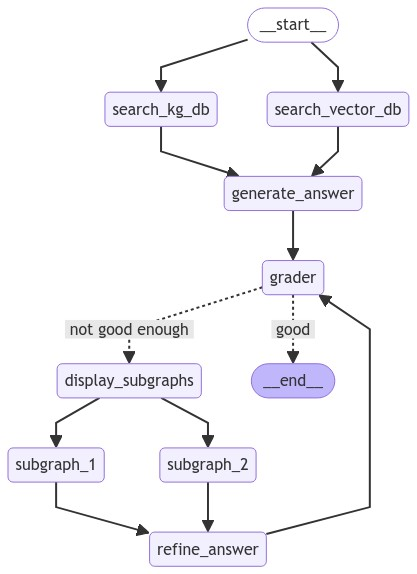

In [48]:
graph_png = graph.get_graph().draw_mermaid_png(
    curve_style=CurveStyle.LINEAR,
    wrap_label_n_words=4,
    output_file_path=None,
    draw_method=MermaidDrawMethod.API,
    background_color="#000000",
    padding=10,
)

graph_base64 = base64.b64encode(graph_png).decode("utf-8")

HTML(f'''
<div style="display: flex; justify-content: center;">
    <img src="data:image/png;base64,{graph_base64}" width="400" height="auto"/>
</div>
''')